# Week 04: Multi-class Classification

## Introduction


In this exercise, we will implement logistic regression based multiclass classification to recognize handwritten digits. 

In [68]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Module to load MATLAB .mat datafile format (Input and output module of scipy)
from scipy.io import loadmat

# Python Imaging Library (PIL)
from PIL import Image

#functool will be needed for plotting the losses
from functools import partial

#To read the fashion mnist dataset
import pandas as pd

#Setting some parameters of pyplot
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"

In [69]:
DATA_DIR = 'data'
SAVE_DIR = "plots"

# MNIST Digits

## Multi-class Classification

For this exercise, logistic regression will be used to recognize handwritten digits (from 0 to 9).

### Dataset

The data set is given in `mnist-digit.mat` that contains 5000 training examples of handwritten digits. Use the function `loadmat` within the `scipy.io` module to load the data.

There are 5000 training examples in `mnist-digit.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set.



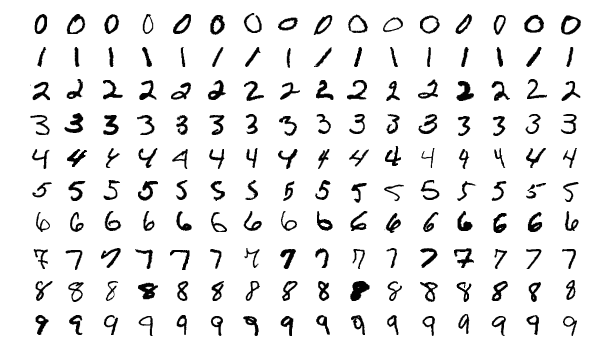

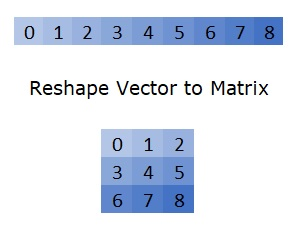

In [70]:
# Load data
data = loadmat(os.path.join(DATA_DIR, 'mnist-digit.mat'))
X, y = data['X'], data['y'].ravel()


# 10 labels, from 1 to 10 (note that you have to map "0" to label "10")
y[y == 10] = 0

# m = Number of examples
m = y.size


### MATLAB Data

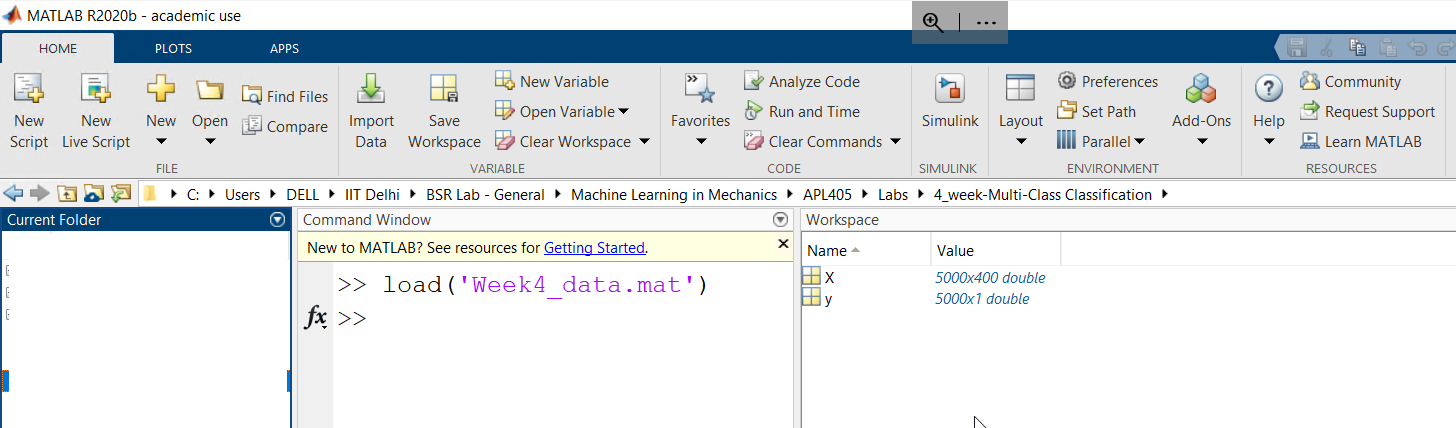

### Definition of useful functions that are going to be used thoughout the code

In [71]:
def displayData(X, y, file_name="0101.png"):
    """
    Displays the data from X. Plots images with corresponding labels in y.

    Parameters
    -----------
    X : array_like
        An array of shape (m, n) where m is the number of examples, and n is the
        number of features for each example.
    
    y : array_like
        An array of shape (m, ) that contains labels for X. Each value in y
    
    Instructions
    ------------
    Display in a grid of 10 by 10 the first 100 images from X. It is recommended
    that you pass just 100 images to this function.
    """
    plt.figure(figsize=(12, 12))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(X[i, :].reshape(20, 20).T, cmap="binary")
        plt.title(int(y[i]))
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, file_name))
       
def sigmoid(z):
    """
    Calculates the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

### Visualize the data

To visualize the data that you imported, randomly selects 100 rows from `X` and passes those rows to the `displayData` function.

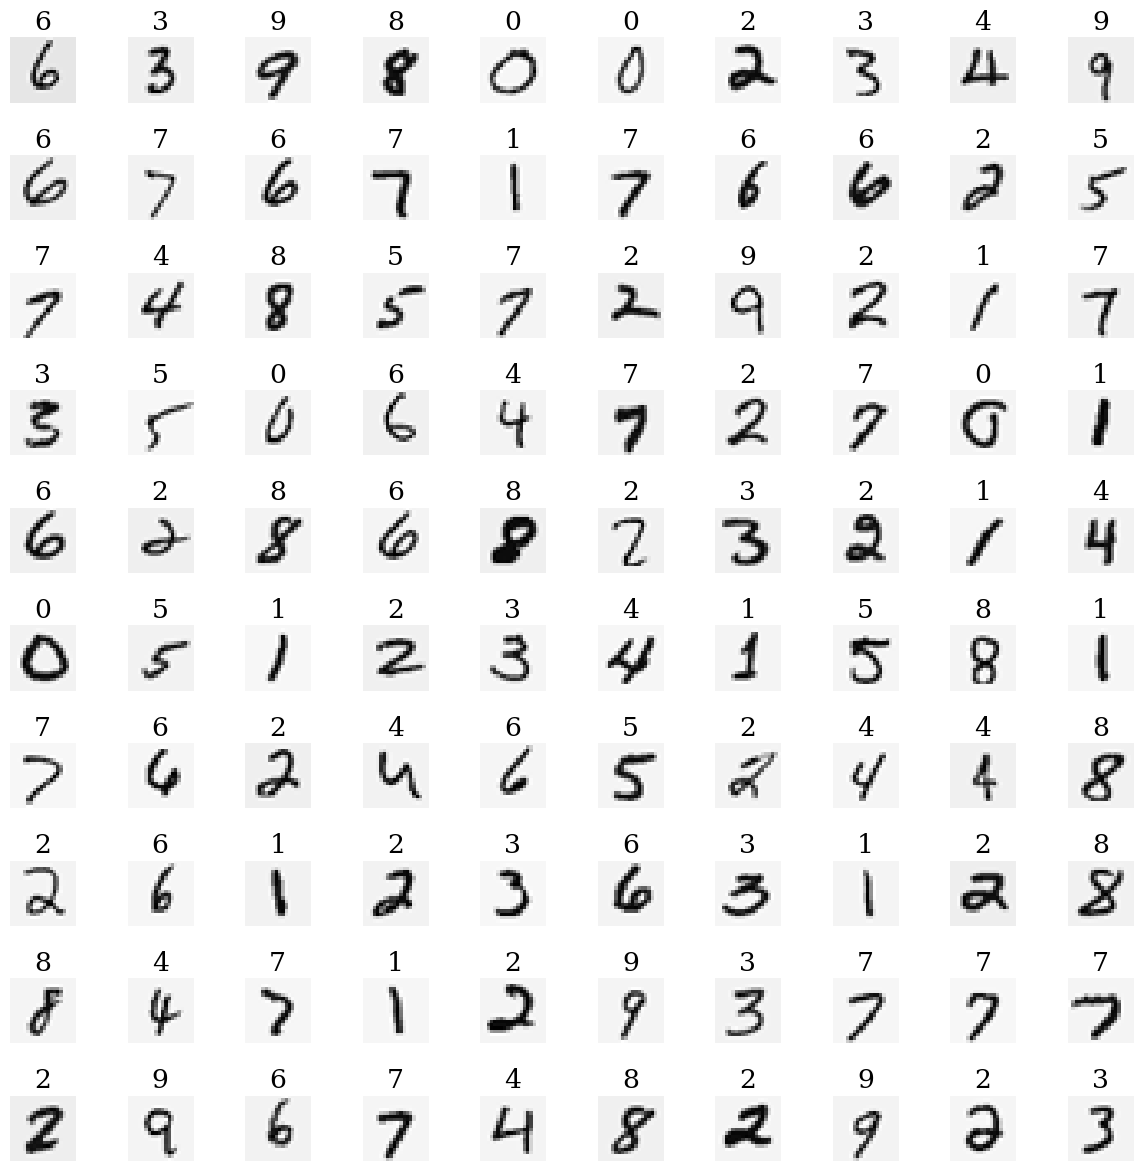

In [72]:
# Randomly select data points to display
rand_indices = np.random.choice(m, 100, replace=False)
X_sample = X[rand_indices, :]
y_sample = y[rand_indices]
d = displayData(X_sample, y_sample)

<a id="section1"></a>
#### Vectorizing the cost function 

Begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_w\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_w \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_w(x^{(i)})$ for every example $i$, where $h_w(x^{(i)}) = g(w^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $w$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad w = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{bmatrix} $$

Then, by computing the matrix product $Xw$, we have: 

$$ Xw = \begin{bmatrix} - \left( x^{(1)} \right)^Tw - \\ - \left( x^{(2)} \right)^Tw - \\ \vdots \\ - \left( x^{(m)} \right)^Tw - \end{bmatrix} = \begin{bmatrix} - w^T x^{(1)}  - \\ - w^T x^{(2)} - \\ \vdots \\ - w^T x^{(m)}  - \end{bmatrix} $$

#### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_w\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $w_j$,

$$
\begin{aligned}
\begin{bmatrix} 
\frac{\partial J}{\partial w_0} \\
\frac{\partial J}{\partial w_1} \\
\frac{\partial J}{\partial w_2} \\
\vdots \\
\frac{\partial J}{\partial w_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_w(x) - y\right)
\end{aligned}
$$

where

$$  h_w(x) - y = 
\begin{bmatrix}
h_w\left(x^{(1)}\right) - y^{(1)} \\
h_w\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_w\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_w\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_w\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_w(x^{(i)} - y^{(i)}) \right)$.

Now the job is to define a new function (`lrCostFunction`) which will take the data (vectors `X` and `y`) and parameter (`Lambda`) as input and return the cost as a scalar. 

#### Regularized logistic regression

Now add regularization to the cost function. For regularized logistic regression, the cost function is defined as

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_w\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_w \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2 $$

Note that $w_0$ should not be regularized as it is used as bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $w_j$ is defined as

$$
\begin{aligned}
& \frac{\partial J(w)}{\partial w_0} = \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(w)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} w_j & \text{for } j  \ge 1
\end{aligned}
$$

In [73]:
#adding the bias term
m, n = X.shape
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Let's create a train test split:

In [74]:
np.random.seed(42)
ratio = 0.7
ids = np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids = ids[:int(ratio * X.shape[0])]
test_ids = ids[int(ratio * X.shape[0]):]
X_train, y_train = X[train_ids], y[train_ids]
X_test, y_test = X[test_ids], y[test_ids]

assert len(X_train) + len(X_test) == len(X)
assert len(X_train)>len(X_test)

In [75]:
def lrCostFunction(w, X, y, lambda_):
    
    m = y.size
    J = 0
    grad = np.zeros(w.shape)
    
    h = sigmoid(np.dot(X,w))
    
    J = (1/m)*np.sum(-y*np.log(h + 1e-10)-(1-y)*np.log(1-h + 1e-11)) + (lambda_/(2*m))*np.sum(w[1:]**2)
    
    grad = (1/m)*np.dot(X.T,(h-y)) + (lambda_/m)*w

    # As we don't want to regularize the bias term
    grad[0] = (1/m)*np.dot(X.T,(h-y))[0]
    
    return J , grad

In [76]:
w_initial = np.zeros(X.shape[1])
lambda_ = 0.1
J, grad = lrCostFunction(w_initial, X, y, lambda_)
assert J.shape == ()
assert grad.shape == (401,)

<a id="section2"></a>
### Multi-class Classification MNIST Digits

In this part of the exercise, you will implement multi-class classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset.

Code for the function `oneVsAll` below, to train one classifier for each class. In particular, the code should return all the classifier parameters in a matrix $w \in \mathbb{R}^{K \times (N +1)}$, where each row of $w$ corresponds to the learned logistic regression parameters for one class. One can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

The obvious approach is to use a one-versus-the-rest approach (also called one-vs-all), in which we train C binary classifiers, fc(x), where the data from class c is treated as positive, and the data from all the other classes is treated as negative.

<a id="oneVsAll"></a>

In [77]:
def callback_history(w, label, histories, X, y):
    global cur_epoch
    print(f"Epoch: {cur_epoch:3d} | Label: {label:1d}", end="\r", flush=True)
    y_temp = (y == label).astype(int)
    J, _= lrCostFunction(w, X, y_temp, lambda_)
    if label not in histories:
        histories[label] = []
    histories[label].append(J)
    cur_epoch += 1

In [78]:
cur_epoch = 1
def oneVsAll(X, y, num_labels, lambda_, method="CG"):
    global cur_epoch
    m, n = X.shape
    
    all_w = np.zeros((num_labels, n))
    histories = {}
    for c in np.arange(num_labels):
        initial_w = all_w[c,:]
        y_temp = (y == c).astype(int)
        callback = partial(callback_history, label=c, histories=histories, X = X, y = y)
        res = optimize.minimize(lrCostFunction, initial_w, (X, y_temp, lambda_), jac=True, method=method, options={'maxiter': 500}, callback=callback, tol=1e-6)
        all_w[c,:] = res.x
        cur_epoch = 1
        
    return all_w, histories

After complting the code for `oneVsAll`, the following cell shall use the code to train a multi-class classifier. 

In [79]:
lambda_ = 0.1
all_w_digits, history_digits = oneVsAll(X_train, y_train, 10, lambda_, method = "CG")

Let's see how many iteration had it taken for the algorith to converge for the particular label.

In [80]:
for k, v in history_digits.items():
    print(f"Number of iterations for CG method for number {k} is {len(v)}")

Number of iterations for CG method for number 0 is 155
Number of iterations for CG method for number 1 is 142
Number of iterations for CG method for number 2 is 283
Number of iterations for CG method for number 3 is 299
Number of iterations for CG method for number 4 is 294
Number of iterations for CG method for number 5 is 341
Number of iterations for CG method for number 6 is 183
Number of iterations for CG method for number 7 is 214
Number of iterations for CG method for number 8 is 385
Number of iterations for CG method for number 9 is 331


Let's also see some of the weights learned:

In [81]:
print("Shape of the weight", all_w_digits.shape)
all_w_digits[0, :10]

Shape of the weight (10, 401)


array([-7.27770273e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.29885183e-05,  7.10886952e-04,  6.58787690e-03,  1.68796199e-03,
       -1.77194582e-04, -1.28622460e-04])

<a id="section3"></a>
#### Multi-class Prediction

After training one-vs-all classifier, one can now use it to predict the digit contained in a given image. For each input, one should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example.
<a id="predictOneVsAll"></a>

In [82]:
def predictOneVsAll(all_w, X):
        
    m = X.shape[0]
    num_labels = all_w.shape[0]

    preds = sigmoid(np.dot(X,all_w.T))
    predict = np.argmax(preds, axis=1)

    return predict

Now, call `predictOneVsAll` function using the learned value of $w$. One should see the training set accuracy in percentage which shows that the algorithm classifies `p%` of the examples in the training set correctly.

In [83]:
y_train_pred = predictOneVsAll(all_w_digits, X_train)
accuracy_train_digits =  np.mean(y_train_pred == y_train) * 100
print(f'Training Set Accuracy: {accuracy_train_digits:.2f}%')

Training Set Accuracy: 97.34%


In [84]:
y_pred_test = predictOneVsAll(all_w_digits, X_test)
accuracy_test_digits =  np.mean(y_pred_test == y_test) * 100
print(f'Testing Set Accuracy: {accuracy_test_digits:.2f}%')

Testing Set Accuracy: 90.40%


## Plotting Loss

Finally, let's plot the loss for different labels:

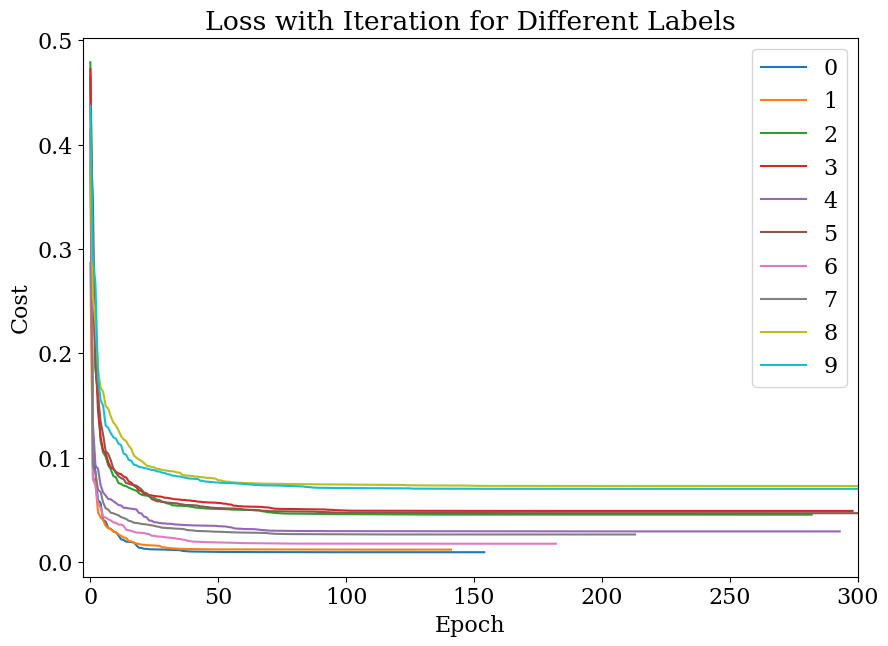

In [85]:
for label, history in history_digits.items():
    plt.plot(history, label=label)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Loss with Iteration for Different Labels")
plt.xlim(-3,300)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "0301.png"))
plt.show()

In [86]:
np.random.seed(101)
m, n = X_train.shape
rand_indices = np.random.choice(m, 100, replace=False)
X_sample = X_train[rand_indices, 1:]
y_sample = y_train_pred[rand_indices]
y_true_sample = y_train[rand_indices]

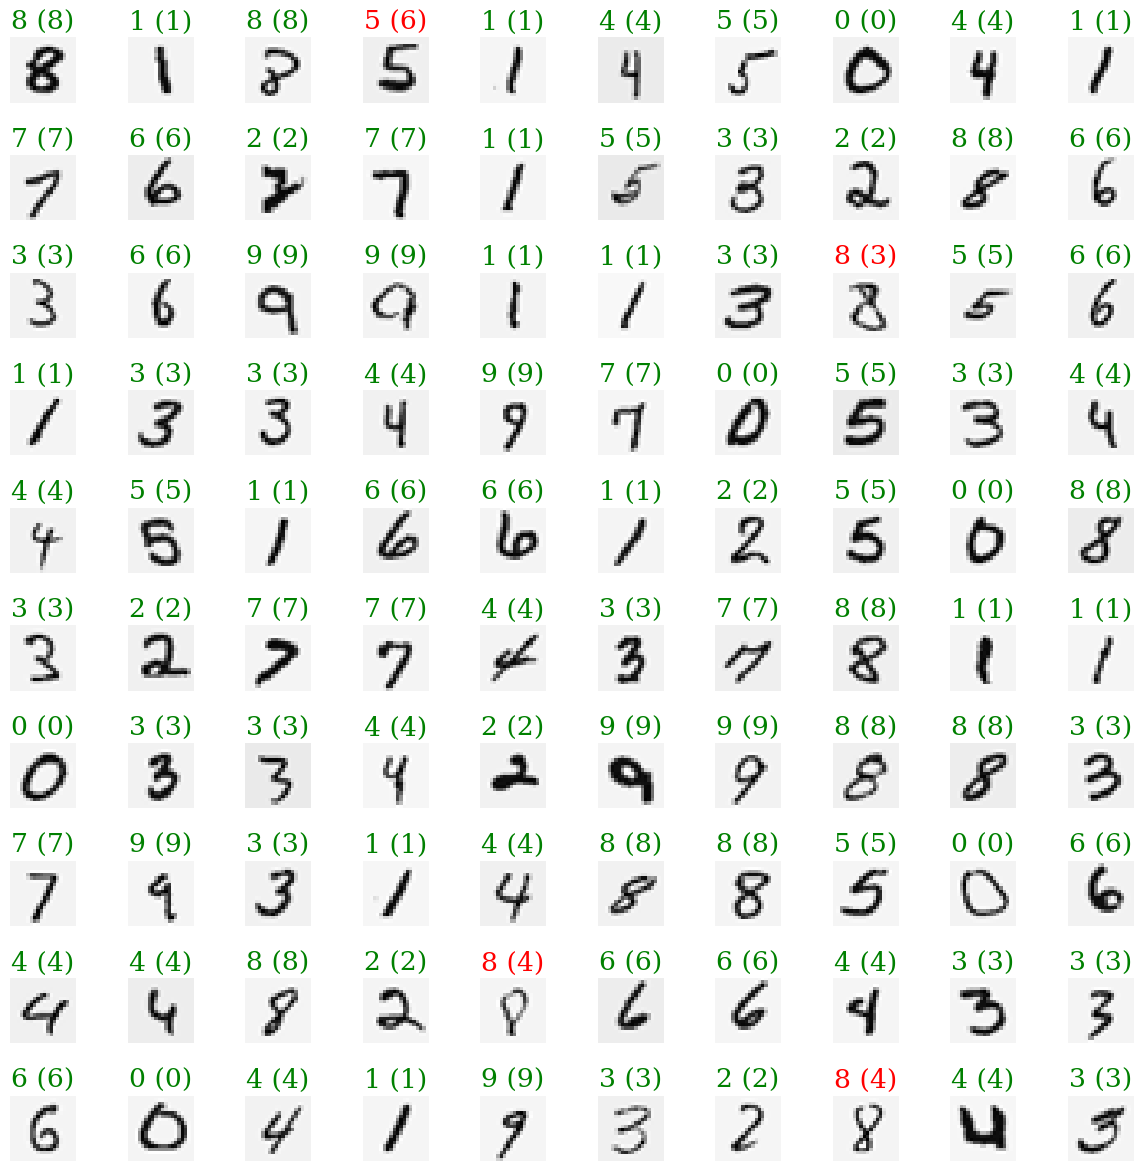

In [87]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_sample[i,].reshape(20, 20).T, cmap="binary")
    true_label = y_true_sample[i]
    pred_label = y_sample[i]
    if true_label != pred_label:
        plt.title(f"{true_label} ({pred_label})", color="red")
    else:
        plt.title(f"{true_label} ({pred_label})", color="green")
    plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "0501.png"))

# MNIST Fashion

Here, we'll fit the same model on the Fashion MNIST dataset.

## Loading the data

Since the test dataset just has 30 images, we'll just load the tranin dataset and make a train-test split.

In [47]:
train = pd.read_csv(os.path.join(DATA_DIR, 'fashion-mnist_train.csv'))

In [48]:
y = train["label"].values
X = train.drop("label", axis=1).values

In [49]:
#adding the bias term
m, n = X.shape
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [50]:
np.random.seed(42)
ratio = 0.7
ids = np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids = ids[:int(ratio * X.shape[0])]
test_ids = ids[int(ratio * X.shape[0]):]
X_train, y_train = X[train_ids], y[train_ids]
X_test, y_test = X[test_ids], y[test_ids]

assert len(X_train) + len(X_test) == len(X)
assert len(X_train)>len(X_test)

## Normalizing the data

We can use the formula

$$
   X_{norm} = \frac{X - min(X)}{max(X) - min(X)}
$$

to normalize the data. However, a lot of values (pixels) in the image are 0 which are also the minimum values. This will cause problem with normalization. So, we'll normalize with the maximum value, which makes more sense in this situation.

In [51]:
X_train = X_train/255.0
X_test = X_test/255.0

## Fitting the model

In [52]:
def callback_history(w, label, histories, X, y):
    global cur_epoch
    print(f"Epoch: {cur_epoch:3d} | Label: {label:1d}", end="\r", flush=True)
    y_temp = (y == label).astype(int)
    J, _= lrCostFunction(w, X, y_temp, lambda_)
    if label not in histories:
        histories[label] = []
    histories[label].append(J)
    cur_epoch += 1

In [55]:
cur_epoch = 1
def oneVsAll(X, y, num_labels, lambda_, method="CG"):
    global cur_epoch
    m, n = X.shape
    
    all_w = np.zeros((num_labels, n))
    histories = {}
    for c in np.arange(num_labels):
        initial_w = all_w[c,:]
        y_temp = (y == c).astype(int)
        callback = partial(callback_history, label=c, histories=histories, X = X, y = y)
        res = optimize.minimize(lrCostFunction, initial_w, (X, y_temp, lambda_), jac=True, method=method, options={'maxiter': 300}, callback=callback, tol=1e-6)
        all_w[c,:] = res.x
        cur_epoch = 1
        
    return all_w, histories

In [56]:
lambda_ = 0.1
all_w_fashion, history_fashion = oneVsAll(X_train, y_train, 10, lambda_, method = "CG")

Let's see how many iteration had it taken for the algorith to converge for the particular label.

In [57]:
for k, v in history_fashion.items():
    print(f"Number of iterations for CG method for label {k} is {len(v)}")

Number of iterations for CG method for label 0 is 300
Number of iterations for CG method for label 1 is 300
Number of iterations for CG method for label 2 is 300
Number of iterations for CG method for label 3 is 300
Number of iterations for CG method for label 4 is 300
Number of iterations for CG method for label 5 is 300
Number of iterations for CG method for label 6 is 300
Number of iterations for CG method for label 7 is 300
Number of iterations for CG method for label 8 is 300
Number of iterations for CG method for label 9 is 300


Let's also see some of the weights learned:

In [58]:
print("Shape of the weight", all_w_fashion.shape)
all_w_fashion[0, :10]

Shape of the weight (10, 785)


array([-2.92572919e-01, -2.13439414e-05,  3.36538628e-03, -3.78033848e-02,
       -6.78746828e-02, -3.52905000e-01, -7.50741506e-01, -1.27801519e+00,
       -1.21028762e+00, -2.42418328e-01])

In [59]:
y_train_pred = predictOneVsAll(all_w_fashion, X_train)
accuracy_train_fashion =  np.mean(y_train_pred == y_train) * 100
print(f'Training Set Accuracy: {accuracy_train_fashion:.2f}%')

Training Set Accuracy: 94.16%


In [60]:
y_pred_test = predictOneVsAll(all_w_fashion, X_test)
accuracy_test_fashion =  np.mean(y_pred_test == y_test) * 100
print(f'Testing Set Accuracy: {accuracy_test_fashion:.2f}%')

Testing Set Accuracy: 82.03%


## Plots

Let's also see the loss for different labels:

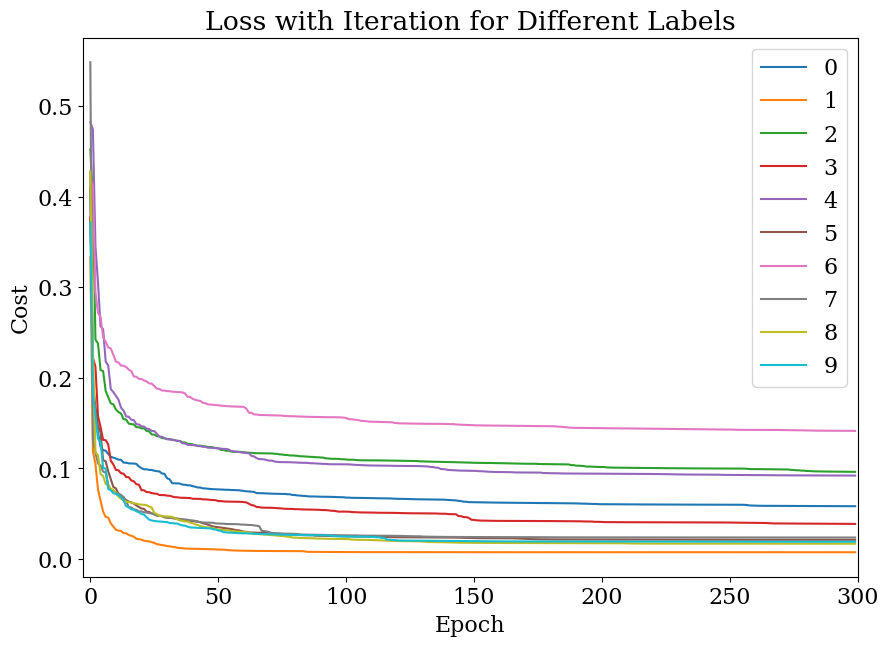

In [63]:
for label, history in history_fashion.items():
    plt.plot(history, label=label)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Loss with Iteration for Different Labels")
plt.xlim(-3,300)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "0302.png"))
plt.show()

In [62]:
np.random.seed(101)
m, n = X_train.shape
rand_indices = np.random.choice(m, 100, replace=False)
X_sample = X_train[rand_indices, 1:]
y_sample = y_train_pred[rand_indices]
y_true_sample = y_train[rand_indices]

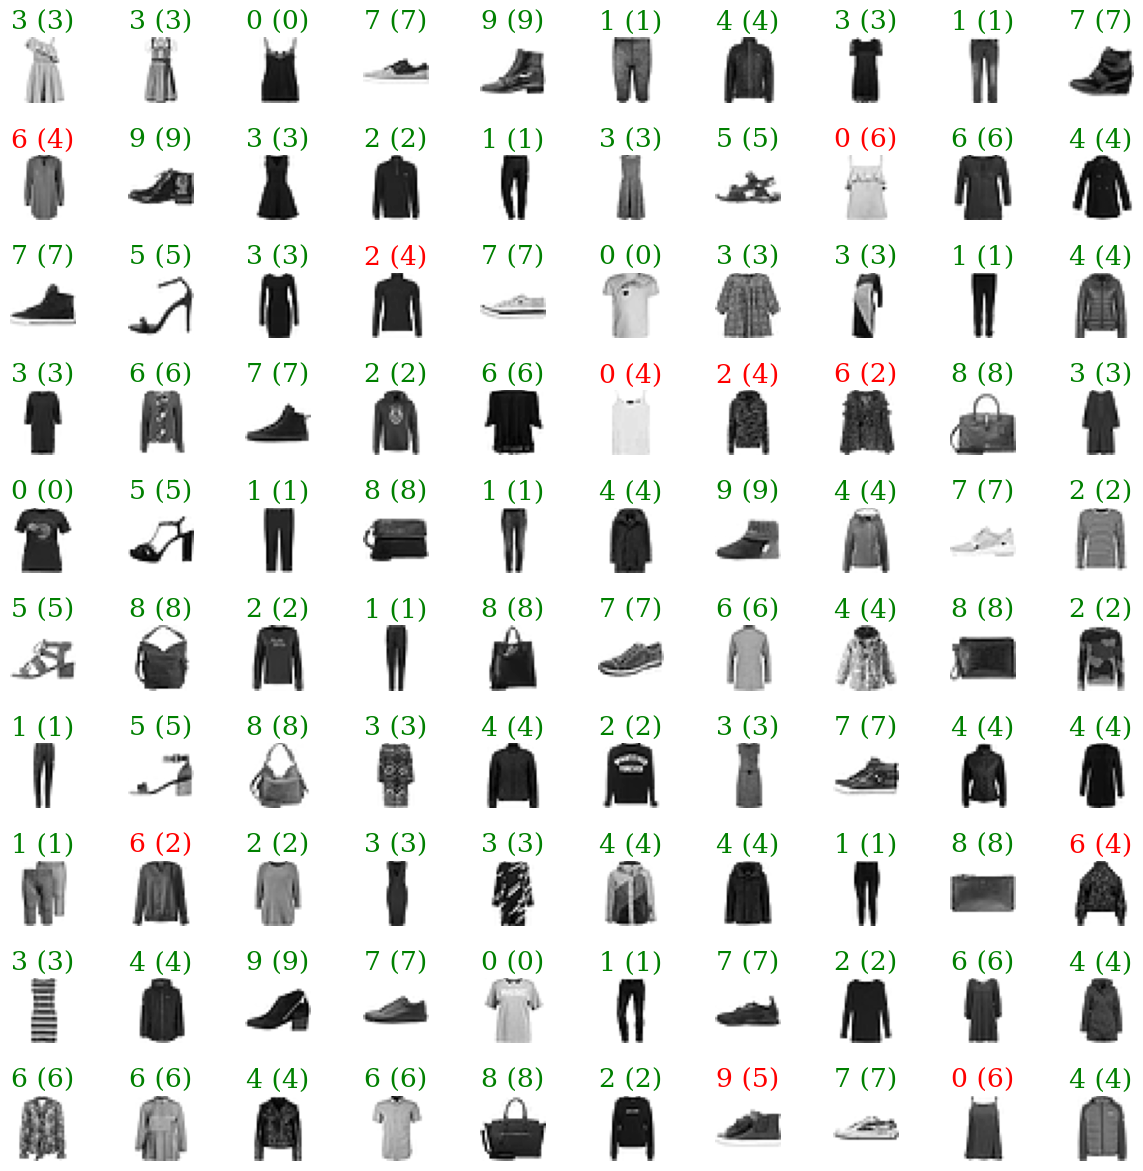

In [67]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_sample[i,].reshape(28, 28), cmap="binary")
    true_label = y_true_sample[i]
    pred_label = y_sample[i]
    if true_label != pred_label:
        plt.title(f"{true_label} ({pred_label})", color="red")
    else:
        plt.title(f"{true_label} ({pred_label})", color="green")
    plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "0502.png"))